# EmojiPred 

### Loading glove embeddings

In [1]:
import gensim
import gensim.downloader
from gensim.models import KeyedVectors
import pandas
import string
import pandas as pd
import collections
import itertools
import numpy as np
import pickle 
import nltk
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import random

In [4]:
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

In [5]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow_hub as hub

# Tensorflow GPU check
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

2021-11-28 04:49:19.200759: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 13440 MB memory:  -> device: 0, name: Quadro P5000, pci bus id: 0000:03:00.0, compute capability: 6.1


True

### Parameters

In [6]:
embed_path = 'embeddings/twitter_27B_200d.kv'
embed_dim = 200
emb_model = KeyedVectors.load(embed_path)

lang = 'bengali'
data_path = 'data/indian-langs/bengali_tweets_translated.csv'
label_map = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9, 10:10, 12:11, 13:12, 14:13, 15:14, 16:15, 17:16, 18:17, 19:18}
min_len = 2
max_len = 15
max_pad_len = 10
num_classes = 19

In [7]:
df = pd.read_csv(data_path)
df.head()

,tweet,label
0,first of all on behalf of the stupidians i wou...,6
1,you give me,14
2,eid mubarak eid mubarak ha bhai day test for o...,2
3,little silent the picture i took on my st birt...,1
4,salute to those girls who now eat flour bread ...,2


In [8]:
print("Before:\n", df.isnull().sum())
df = df.dropna()
print("\nAfter:\n", df.isnull().sum())

Before:
 tweet    1220
label       0
dtype: int64

After:
 tweet    0
label    0
dtype: int64


In [9]:
# nltk.download('stopwords')
from nltk.corpus import stopwords
# stopwords.words('english')

In [10]:
def remove_stopwords(text):
    word_list = []
    for i in text.split():
        if i not in stopwords.words('english'):
            word_list.append(i)
    text_clean = " ".join(word_list)
    return text_clean

In [11]:
df['tweet'] = df['tweet'].apply(remove_stopwords)

In [12]:
df['token'] = df['tweet'].apply(lambda x: x.split())
df['len'] = df['token'].apply(lambda x: len(x))
df['label'] = df['label'].apply(lambda x: label_map[x])
df.head()

,tweet,label,token,len
0,first behalf stupidians would like inform ever...,6,"[first, behalf, stupidians, would, like, infor...",13
1,give,13,[give],1
2,eid mubarak eid mubarak ha bhai day test days ...,2,"[eid, mubarak, eid, mubarak, ha, bhai, day, te...",11
3,little silent picture took st birthday one too...,1,"[little, silent, picture, took, st, birthday, ...",13
4,salute girls eat flour bread instead flour flour,2,"[salute, girls, eat, flour, bread, instead, fl...",8


In [13]:
temp = sorted(df['label'].value_counts().index)
print(temp, "\n", len(temp))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] 
 19


In [14]:
df['len'].value_counts()

9      6954
10     6743
8      6193
11     5996
12     5147
7      4976
6      3800
13     3769
5      2622
14     2585
4      1913
15     1704
3      1374
2      1148
16     1008
1       839
17      566
18      298
0       252
19      147
20       86
21       37
22       29
24       13
25       10
23        7
26        5
31        3
29        3
37        2
48        2
28        2
47        1
39        1
148       1
44        1
34        1
41        1
45        1
Name: len, dtype: int64

<AxesSubplot:xlabel='len', ylabel='count'>

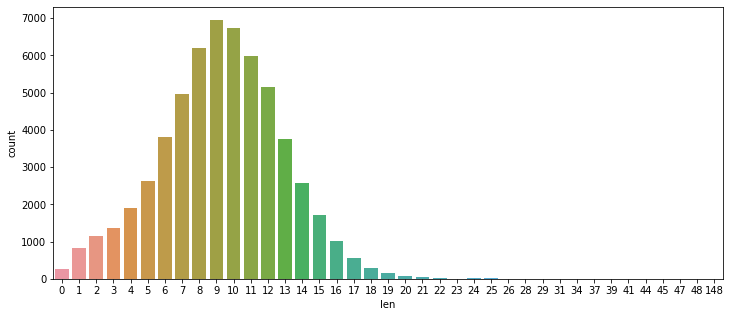

In [15]:
plt.figure(figsize=(12, 5))
sns.countplot(x=df['len'])

In [16]:
filter_idx = (df['len'] <= max_len)
df = df[filter_idx]
filter_idx = (df['len'] >= min_len)
df = df[filter_idx]
df.describe()

,label,len
count,54924.000000,54924.000000
mean,7.729954,9.155178
std,5.780235,3.070435
min,0.000000,2.000000
25%,2.000000,7.000000
50%,6.000000,9.000000
75%,13.000000,11.000000
max,18.000000,15.000000


In [17]:
# Universal Sentence Encoder
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
univ_model = hub.load(module_url)
# univ_model = hub.load('models/use-4')
print ("module %s loaded" % module_url)

2021-11-28 04:50:49.250330: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13440 MB memory:  -> device: 0, name: Quadro P5000, pci bus id: 0000:03:00.0, compute capability: 6.1
2021-11-28 04:50:51.298997: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [18]:
df['sent'] = df['tweet'].progress_apply(lambda x: np.array(univ_model([x])).flatten())

  0%|          | 0/54924 [00:00<?, ?it/s]

In [25]:
def add_embeddings(data):
    
    emb_data = []
    for word in data:
        if word not in emb_model.key_to_index:
            pass
        else:
            word_emb = emb_model[word] 
            emb_data.append(word_emb)
        
    # check if padding / clipping required
    pad = False
    clip = False
    if len(emb_data) < max_pad_len:
        pad = True
    elif len(emb_data) > max_pad_len:
        clip = True
    else:
        pad = clip = False
        
    # padding
    if pad:
        deficiency = max_pad_len - len(emb_data)
        for pad in range(deficiency):
            emb_data.append(np.zeros(embed_dim))
            
    elif clip:
        # Taking last few tokens
        surplus = len(emb_data) - max_pad_len
        emb_data = emb_data[(-max_pad_len):]
      
    emb_data = np.array(emb_data, dtype=float)
    # print(emb_data.shape, emb_data.shape==(max_pad_len, embed_dim))
    
    return emb_data


In [26]:
df['emb_matrix'] = df['token'].progress_apply(add_embeddings)

  0%|          | 0/54924 [00:00<?, ?it/s]

In [27]:
df['emb_flatten'] = df['emb_matrix'].progress_apply(lambda x: x.flatten())

  0%|          | 0/54924 [00:00<?, ?it/s]

In [28]:
df.head()

,tweet,label,token,len,sent,emb_matrix,emb_flatten
0,first behalf stupidians would like inform ever...,6,"[first, behalf, stupidians, would, like, infor...",13,"[-0.008306882, -0.039416127, -0.04187309, -0.0...","[[-0.29868000745773315, 0.30234000086784363, -...","[-0.29868000745773315, 0.30234000086784363, -0..."
2,eid mubarak eid mubarak ha bhai day test days ...,2,"[eid, mubarak, eid, mubarak, ha, bhai, day, te...",11,"[0.0033559694, -0.06630455, 0.005606277, 0.001...","[[0.9207599759101868, 0.5291699767112732, -0.5...","[0.9207599759101868, 0.5291699767112732, -0.54..."
3,little silent picture took st birthday one too...,1,"[little, silent, picture, took, st, birthday, ...",13,"[-0.0813372, -0.0011281285, 0.015300999, 0.040...","[[0.2847599983215332, 0.037039000540971756, 0....","[0.2847599983215332, 0.037039000540971756, 0.0..."
4,salute girls eat flour bread instead flour flour,2,"[salute, girls, eat, flour, bread, instead, fl...",8,"[0.010586225, -0.01395171, 0.015433515, 0.0352...","[[0.019852999597787857, 0.23251000046730042, 0...","[0.019852999597787857, 0.23251000046730042, 0...."
6,collected post womens society country agrees m...,11,"[collected, post, womens, society, country, ag...",13,"[-0.03689894, -0.029366875, -0.033071045, -0.0...","[[-0.5243600010871887, 0.3364500105381012, 0.2...","[-0.5243600010871887, 0.3364500105381012, 0.26..."


In [29]:
X_tok = np.array(list(df['emb_flatten'].to_numpy()))
print(X_tok.shape)
X_sent = np.array(list(df['sent'].to_numpy()))
print(X_sent.shape)

X = np.concatenate((X_tok, X_sent), axis=1)
y = df['label'].values
# y = to_categorical(y)
X.shape, y.shape

(54924, 2000)
(54924, 512)


((54924, 2512), (54924,))

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(49431, 2512) (5493, 2512) (49431, 19) (5493, 19)


In [46]:
# X = np.array(list(df['emb_matrix'].to_numpy()))
# y = df['label'].values
# y = to_categorical(y)
# X.shape, y.shape

### EmojiPred Architecture

In [47]:
X.shape, y.shape

((54924, 2512), (54924,))

In [48]:
from keras.models import Model, Sequential
from keras.layers.merge import concatenate
from keras.layers import Input, Bidirectional, Embedding, Dense, Dropout, SpatialDropout1D, LSTM, Activation, GlobalMaxPool1D, Conv1D
from keras.regularizers import L1L2
from attention import AttentionWeightedAverage
import numpy as np
from copy import deepcopy
from os.path import exists
import h5py

In [49]:
def emoji_pred(input_dim, num_classes):
    # create model
    model_input = Input(shape=input_dim)
    
    token = model_input[:,:2000]
    print(token.shape)
    token = tf.reshape(token, [tf.shape(token)[0], 10,200])
    sent = model_input[:,-512:]
    print(token.shape, sent.shape)
    
    x = Activation('relu')(token)
    # x = Activation('relu')(token)
    print(x.shape)
    embed_drop = SpatialDropout1D(0.2, name='embed_drop')
    x = embed_drop(x)
    
    # token embeddings are 200, sentence embeddings = 2000
    lstm_0_output = Bidirectional(LSTM(400, return_sequences=True), name="bi_lstm_0")(x)
    print(x.shape)
    lstm_1_output = Bidirectional(LSTM(400, return_sequences=True), name="bi_lstm_1")(lstm_0_output)
    print(x.shape)
    x = concatenate([lstm_1_output, lstm_0_output, x])
    print(x.shape)
    x = GlobalMaxPool1D()(x)
    print(x.shape)
    # x = AttentionWeightedAverage(name='attlayer', return_attention=False)(x)
    
    # Concatenate sentence embeddings
    sent = Dense(200, activation='relu', name='FC-1')(sent)
    print(sent.shape)
    x = concatenate([x, sent])
    print(x.shape)
    outputs = [Dense(num_classes, activation='softmax', name='softmax')(x)]
    # print(outputs.shape)
    
    model = Model(inputs=[model_input], outputs=outputs, name="EmojiPredHindi")
    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [50]:
# Call model
mlp_model = emoji_pred((2512,), num_classes)
history = mlp_model.fit(X_train, y_train, validation_split=0.1, epochs=5, verbose=2)

# Predictions
y_pred_cat = mlp_model.predict(X_test)
y_pred = np.argmax(y_pred_cat, axis=1)

# Accuracy
result = mlp_model.evaluate(X_test, y_test, verbose=0)
model_accuracy = result[1]
y_test = np.argmax(y_test, axis=1)
# model_precision = metrics.precision_score(y_test, y_pred, average='weighted')
# model_recall = metrics.recall_score(y_test, y_pred, average='weighted')
# model_f1 = metrics.f1_score(y_test, y_pred, average='weighted')

print(f">>> Accuracy of model = {(100*model_accuracy):.4f} %\n")
print(classification_report(y_test, y_pred))

(None, 2000)
(None, 10, 200) (None, 512)
(None, 10, 200)
(None, 10, 200)
(None, 10, 200)
(None, 10, 1800)
(None, 1800)
(None, 200)
(None, 2000)
Epoch 1/5
1391/1391 - 20s - loss: 2.3510 - accuracy: 0.2021 - val_loss: 2.3010 - val_accuracy: 0.2199
Epoch 2/5
1391/1391 - 15s - loss: 2.2693 - accuracy: 0.2255 - val_loss: 2.3057 - val_accuracy: 0.2136
Epoch 3/5
1391/1391 - 15s - loss: 2.2218 - accuracy: 0.2407 - val_loss: 2.2750 - val_accuracy: 0.2259
Epoch 4/5
1391/1391 - 15s - loss: 2.1731 - accuracy: 0.2569 - val_loss: 2.2885 - val_accuracy: 0.2265
Epoch 5/5
1391/1391 - 15s - loss: 2.1092 - accuracy: 0.2808 - val_loss: 2.2957 - val_accuracy: 0.2278
>>> Accuracy of model = 23.6847 %

              precision    recall  f1-score   support

           0       0.18      0.07      0.10       299
           1       0.16      0.13      0.14       463
           2       0.23      0.64      0.34       858
           3       0.00      0.00      0.00        67
           4       0.36      0.10      0

/home/sumanyu/anaconda3/envs/ep/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sumanyu/anaconda3/envs/ep/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sumanyu/anaconda3/envs/ep/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Accuracy
result = mlp_model.evaluate(X, y, verbose=0)
model_accuracy = result[1]
print(model_accuracy)

## Top 5 accuracy
If any of model's top-5 predictions matches with the correct result, set 1



In [52]:
def top_5_acc(y_test, y_pred_cat):
    n = y_pred_cat.shape[0]
    plen = y_pred_cat.shape[1]
    top_5 = np.zeros(n)
    
    for i in range(n):
        true_val = y_test[i]
        pred_prob = y_pred_cat[i]
        pred_prob = [(pred_prob[j], j) for j in range(plen)]
        pred_prob = sorted(pred_prob)[::-1]
        pred_prob = pred_prob[:5]
        pred_labels = [k[1] for k in pred_prob]
        # print(pred_labels)
        if true_val in pred_labels:
            top_5[i] = 1
    
    return np.mean(top_5)*100

In [53]:
print(f"Top-5 accuracy of model = {top_5_acc(y_test, y_pred_cat):.4f}")

Top-5 accuracy of model = 69.5977


In [54]:
mlp_model.save('models/emoji_pred_bengali.h5')

### Plot Acc and loss curves

Accuracy

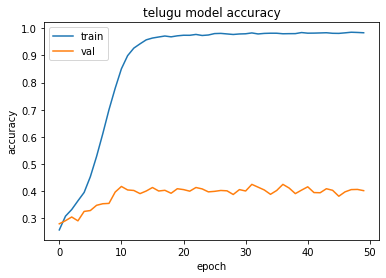

In [65]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(lang+' model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('assets/'+lang+'_acc.png', dpi=300)
plt.show()

Loss

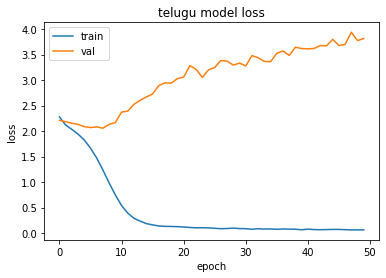

In [71]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(lang+' model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('assets/'+lang+'_loss.png', dpi=300)
plt.show()

### Causal Convolution

In [88]:
def emoji_pred_conv(input_dim, num_classes):
    # create model
    model_input = Input(shape=input_dim)
    x = Activation('relu')(model_input)
    print(x.shape)
    embed_drop = SpatialDropout1D(0.2, name='embed_drop')
    x = embed_drop(x)
    
    conv_1 = Conv1D(512, 3, dilation_rate = [1], padding='causal', activation='relu',name = 'conv_1')(x)
    print(x.shape)
    conv_2 = Conv1D(256, 3, dilation_rate = [2], padding='causal', activation = 'relu',name = 'conv_2')(conv_1)
    print(x.shape)
    conv_3 = Conv1D(128, 3, dilation_rate = [3], padding='causal', activation = 'relu',name = 'conv_3')(conv_2)
    print(x.shape)
    
    # # token embeddings are 200, sentence embeddings = 2000
    # lstm_0_output = Bidirectional(LSTM(400, return_sequences=True), name="bi_lstm_0")(x)
    # print(x.shape)
    # lstm_1_output = Bidirectional(LSTM(400, return_sequences=True), name="bi_lstm_1")(lstm_0_output)
    # print(x.shape)
    # x = concatenate([lstm_1_output, lstm_0_output, x])
    x = concatenate([conv_3, conv_2, conv_1, x])
    print(x.shape)
    x = GlobalMaxPool1D()(x)
    print(x.shape)
    # x = AttentionWeightedAverage(name='attlayer', return_attention=False)(x)
    outputs = [Dense(num_classes, activation='softmax', name='softmax')(x)]
    # print(outputs.shape)
    
    model = Model(inputs=[model_input], outputs=outputs, name="EmojiPredConv")
    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [89]:
# Call model
mlp_model = emoji_pred_conv((10,200), num_classes)
history = mlp_model.fit(X, y, validation_split=0.1, epochs=100, verbose=2)

# Predictions
# y_pred_cat = mlp_model.predict(X)
# y_pred = np.argmax(y_pred_cat, axis=1)

# Accuracy
result = mlp_model.evaluate(X, y, verbose=0)
model_accuracy = result[1]
# y_test = np.argmax(y_test, axis=1)
# model_precision = metrics.precision_score(y_test, y_pred, average='weighted')
# model_recall = metrics.recall_score(y_test, y_pred, average='weighted')
# model_f1 = metrics.f1_score(y_test, y_pred, average='weighted')

print(f">>> Accuracy of MLP model = {(100*model_accuracy):.4f} %\n")

(None, 10, 200)
(None, 10, 200)
(None, 10, 200)
(None, 10, 200)
(None, 10, 1096)
(None, 1096)
Epoch 1/100
1962/1962 - 13s - loss: 2.4596 - accuracy: 0.2830 - val_loss: 2.3376 - val_accuracy: 0.3072
Epoch 2/100
1962/1962 - 12s - loss: 2.3131 - accuracy: 0.3199 - val_loss: 2.2464 - val_accuracy: 0.3342
Epoch 3/100
1962/1962 - 12s - loss: 2.2375 - accuracy: 0.3381 - val_loss: 2.1949 - val_accuracy: 0.3459
Epoch 4/100
1962/1962 - 12s - loss: 2.1626 - accuracy: 0.3546 - val_loss: 2.1277 - val_accuracy: 0.3591
Epoch 5/100
1962/1962 - 12s - loss: 2.0821 - accuracy: 0.3714 - val_loss: 2.0782 - val_accuracy: 0.3732
Epoch 6/100
1962/1962 - 12s - loss: 1.9861 - accuracy: 0.3960 - val_loss: 2.0048 - val_accuracy: 0.3890
Epoch 7/100
1962/1962 - 12s - loss: 1.8893 - accuracy: 0.4193 - val_loss: 1.9704 - val_accuracy: 0.4043
Epoch 8/100
1962/1962 - 12s - loss: 1.7957 - accuracy: 0.4428 - val_loss: 1.9057 - val_accuracy: 0.4239
Epoch 9/100
1962/1962 - 12s - loss: 1.6988 - accuracy: 0.4721 - val_loss: 

KeyboardInterrupt: 

### Model

In [48]:
# Implement tensorflow model for classification

# define classification model
def classification_model(input_dim, num_classes):
    # create model
    model = Sequential()
    model.add(Dense(1000, activation='relu', input_shape=(input_dim,)))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    
    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [50]:
# Call model
mlp_model = classification_model(2000, num_classes)
history = mlp_model.fit(X, y, validation_split=0.1, epochs=1, verbose=2)

# Predictions
y_pred_cat = mlp_model.predict(X_test)
y_pred = np.argmax(y_pred_cat, axis=1)

# Accuracy
result = mlp_model.evaluate(X, y, verbose=0)
model_accuracy = result[1]
# y_test = np.argmax(y_test, axis=1)
# model_precision = metrics.precision_score(y_test, y_pred, average='weighted')
# model_recall = metrics.recall_score(y_test, y_pred, average='weighted')
# model_f1 = metrics.f1_score(y_test, y_pred, average='weighted')

print(f">>> Accuracy of MLP model = {(100*model_accuracy):.4f} %\n")

Epoch 1/10
1962/1962 - 6s - loss: 2.5144 - accuracy: 0.2721 - val_loss: 2.3404 - val_accuracy: 0.2979
Epoch 2/10
1962/1962 - 5s - loss: 2.3098 - accuracy: 0.3143 - val_loss: 2.2092 - val_accuracy: 0.3297
Epoch 3/10
1962/1962 - 5s - loss: 2.0977 - accuracy: 0.3616 - val_loss: 2.0612 - val_accuracy: 0.3708
Epoch 4/10
1962/1962 - 5s - loss: 1.8165 - accuracy: 0.4305 - val_loss: 1.9210 - val_accuracy: 0.4292
Epoch 5/10
1962/1962 - 5s - loss: 1.5087 - accuracy: 0.5156 - val_loss: 1.8275 - val_accuracy: 0.4748
Epoch 6/10
1962/1962 - 5s - loss: 1.2279 - accuracy: 0.6006 - val_loss: 1.7778 - val_accuracy: 0.5146
Epoch 7/10
1962/1962 - 5s - loss: 1.0094 - accuracy: 0.6692 - val_loss: 1.7947 - val_accuracy: 0.5406
Epoch 8/10
1962/1962 - 5s - loss: 0.8549 - accuracy: 0.7204 - val_loss: 1.8501 - val_accuracy: 0.5557
Epoch 9/10
1962/1962 - 5s - loss: 0.7362 - accuracy: 0.7608 - val_loss: 1.8747 - val_accuracy: 0.5712
Epoch 10/10
1962/1962 - 5s - loss: 0.6428 - accuracy: 0.7893 - val_loss: 1.9395 - 